In [1]:
#start imports
import os
from PIL import Image,ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import json
import pandas as pd
from skimage.measure import regionprops_table, label

fileDir = "ecoli_plate_images/tween/time_2/" #enter the file directory of the images you want processed here
fileNameArray = sorted(os.listdir(fileDir)) #creates an array of the file names here

Converts your images into arrays and stores them in imgarrList

In [2]:
#creates a list of arrays of all of your images
#at every x,y position, has three values that correspond to RGB values from 0-255
#only works for JPGs
imgarrList={}
for filename in fileNameArray:
    tempImg = Image.open(fileDir +filename)
    imgarrList[filename]= np.array(tempImg)

Makes a black circle image to then multiple all otehr images by

In [3]:
xCenter= 1300 #set these values to make sure that everything aligns
yCenter=880
radius=520 #normally 520
  
# creating luminous image to then be stacked with current images
lum_img = Image.new('L',[2400,1600] ,0)  
draw = ImageDraw.Draw(lum_img) 
draw.pieslice([xCenter-radius, yCenter-radius, xCenter+radius, yCenter+radius],0,360,fill=255) 
lum_img_arr = np.array(lum_img) #y,x

temp_img_arr = np.array(imgarrList[fileNameArray[0]]) #y,x,z

#combine the two matrices
for y in range(1600):
    for x in range(2400):
        if lum_img_arr[y][x] == False:
            temp_img_arr[y][x]=[0,0,0]

Testing to make sure image works

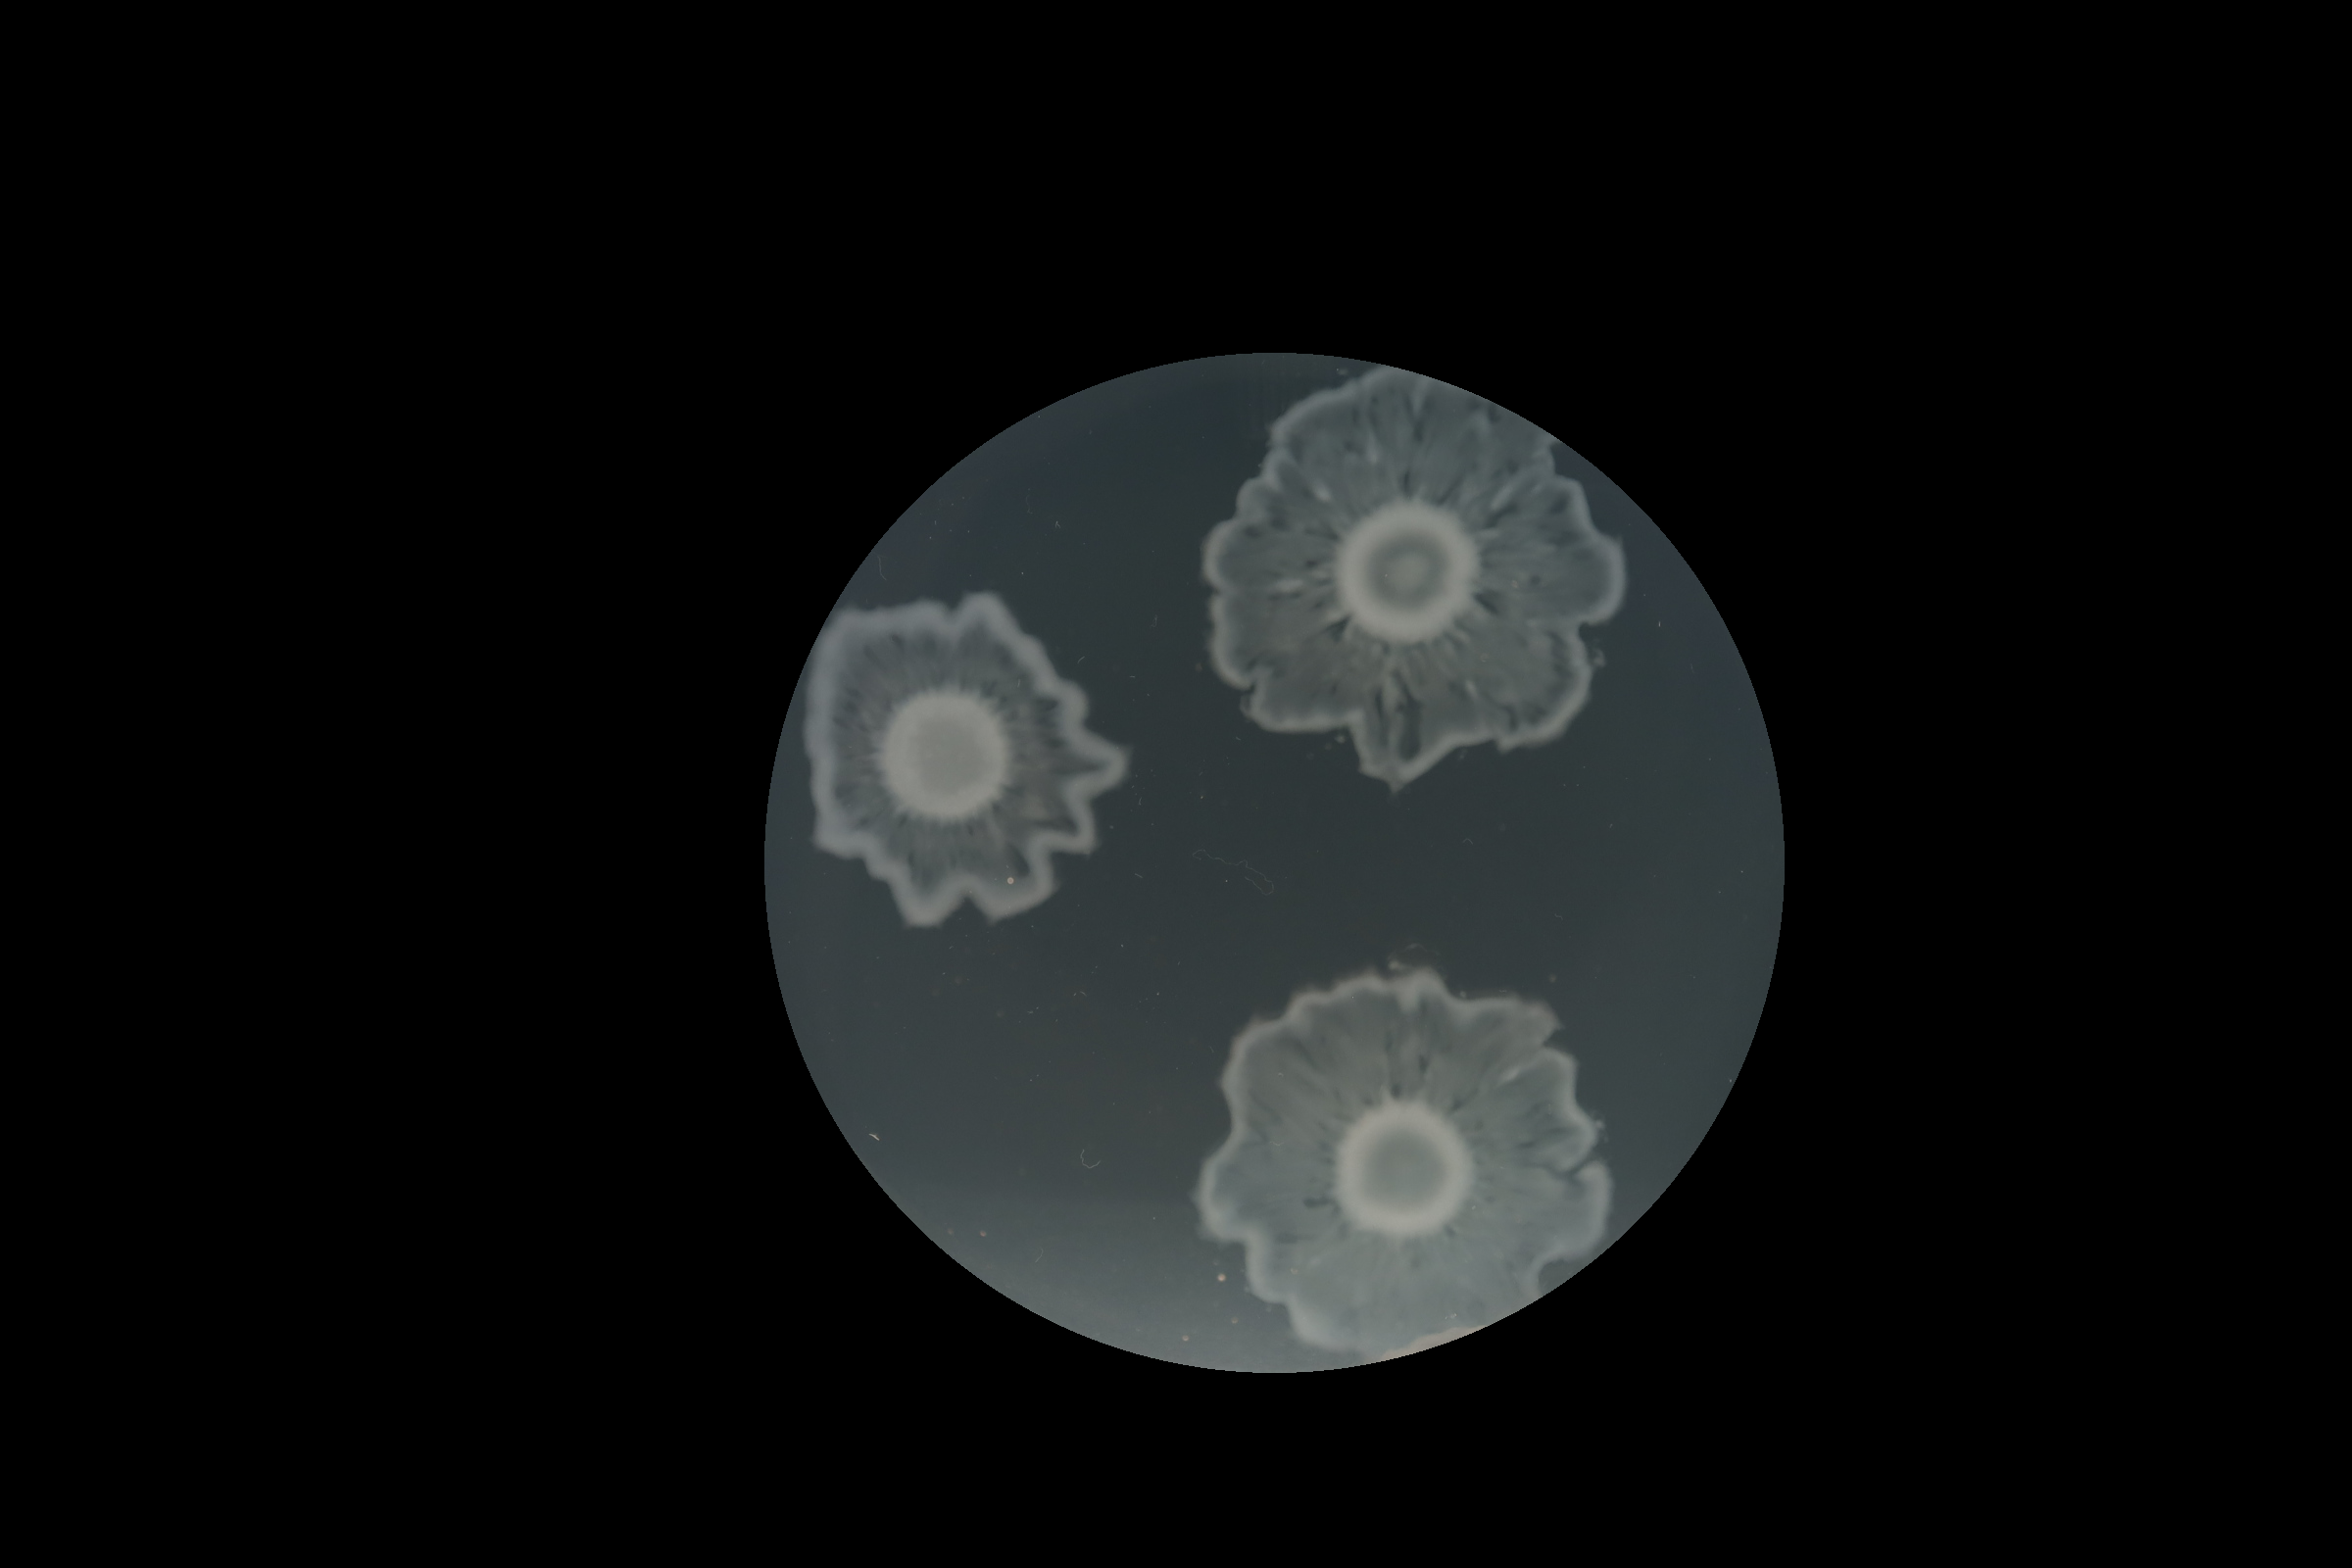

In [4]:
testing_im = Image.fromarray(temp_img_arr, 'RGB')
testing_im

Creating a function which will multiply the current image by the black/circle image

In [5]:
def applyCircFilter(img):
    img_arry=np.array(img)
    for y in range(1600):
        for x in range(2400):
            if lum_img_arr[y][x] == False:
                img_arry[y][x]=[0,0,0]
    return img_arry

In [6]:
#applying the function to each image in the initial image array list
circle_ImgArrList = {}
for x in imgarrList.keys():
    circle_ImgArrList[x]=applyCircFilter(imgarrList[x])

Again, testing to make sure that everyhting worked

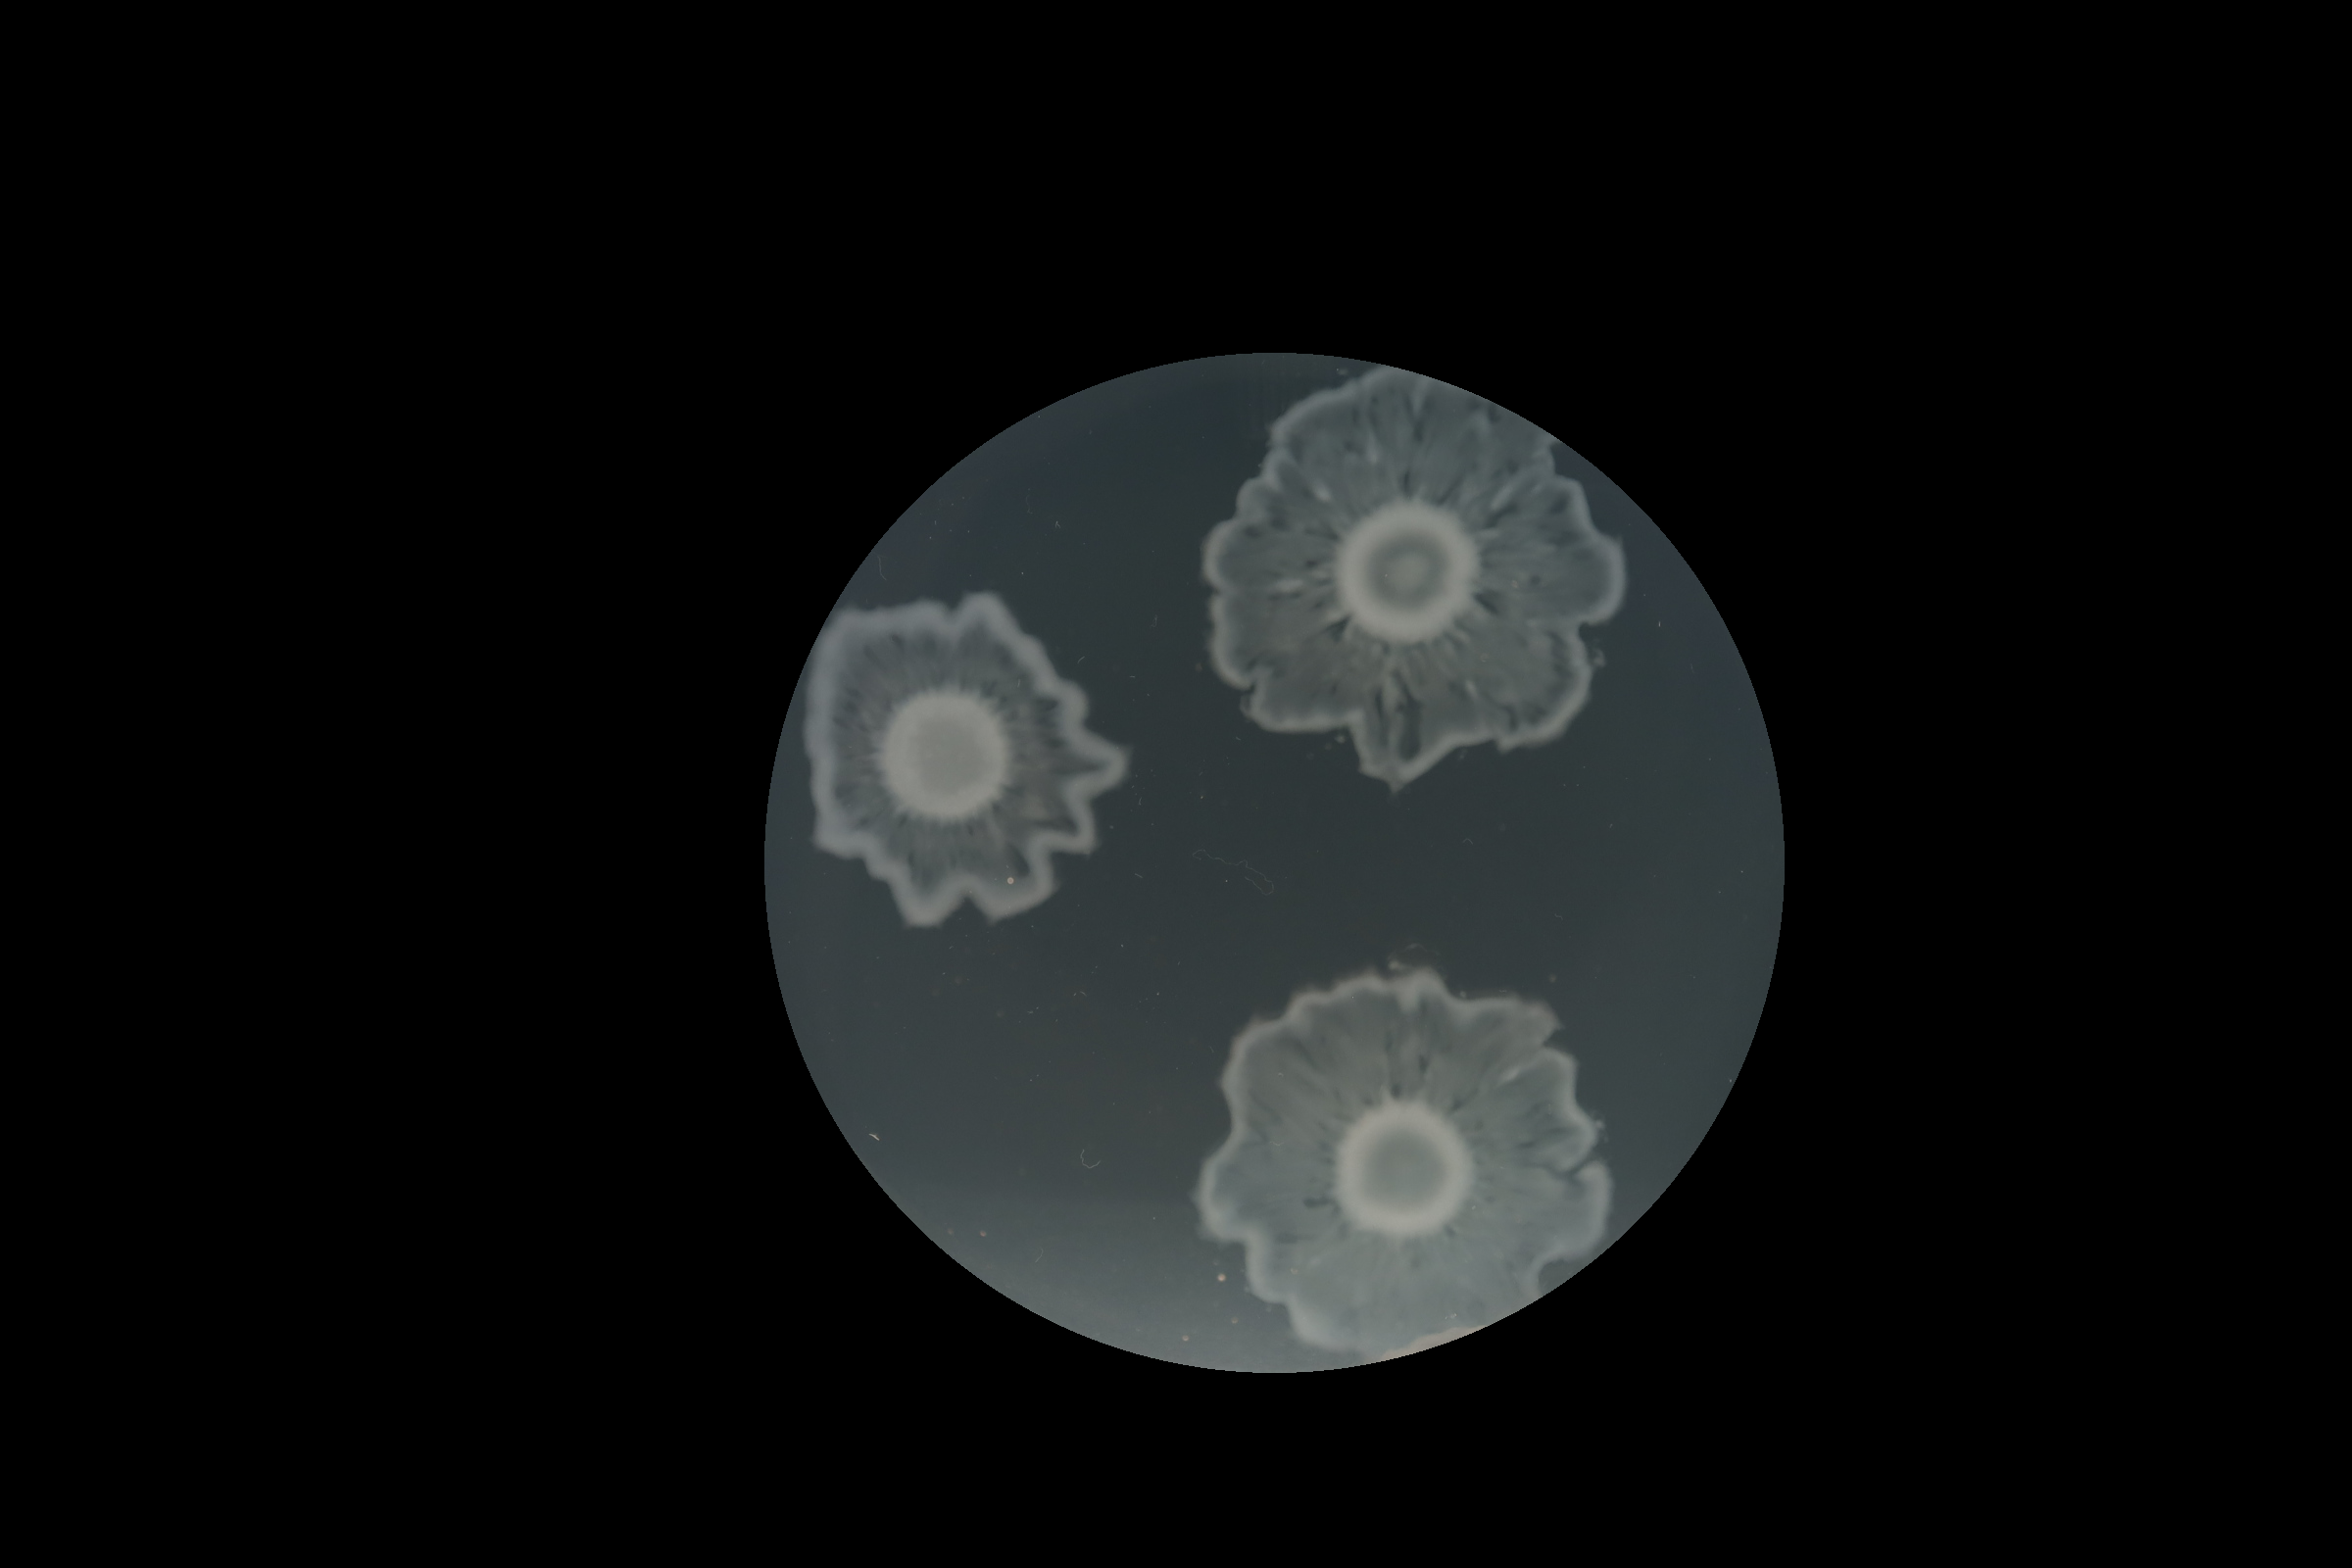

In [7]:
testing_im = Image.fromarray(circle_ImgArrList[fileNameArray[0]], 'RGB')
testing_im

In [9]:
#create the background for subtraction
backgroundImageFile = "ecoli_plate_images/background/background.JPG"
backgroundImageArr=np.array(Image.open(backgroundImageFile))

Now that we have the background image, do the background subtraction

In [10]:
#creates second list of images after subtracting the average generated in the last kernal
finalImageList = {fileName: np.zeros((1600,2400,3), dtype=int) for fileName in fileNameArray}
for imgName in circle_ImgArrList.keys():
    tempArr= np.array(circle_ImgArrList[imgName], dtype = float)
    finalImageList[imgName] = np.array(tempArr - backgroundImageArr.astype(float), dtype=int)
    finalImageList[imgName] = np.array(finalImageList[imgName].clip(min=0), dtype=np.uint8)

Now for the area calculations

In [11]:
#function which will calculate the area of an image array
def calculateArea(imgarr, threshold):
    gray_image = ski.color.rgb2gray(imgarr)
    t = threshold
    binary_mask = gray_image > t
    label_image = label(binary_mask > 0)
    props = regionprops_table(label_image, properties=['label', 'area'])
    #pixelArea = np.sum(binary_mask)
    areas = np.array(np.array(props['area']) * ((90/1040)**2))
    three_areas = np.sort(areas)[-3:]
    return three_areas #pixelArea * ((90/1040)**2)

Creating histogram for determination of thresholding

In [12]:
#creating the images back from array, into an image format
processedImgList = {}
for x in finalImageList.keys():
    processedImgList[x]=Image.fromarray(finalImageList[x], 'RGB')

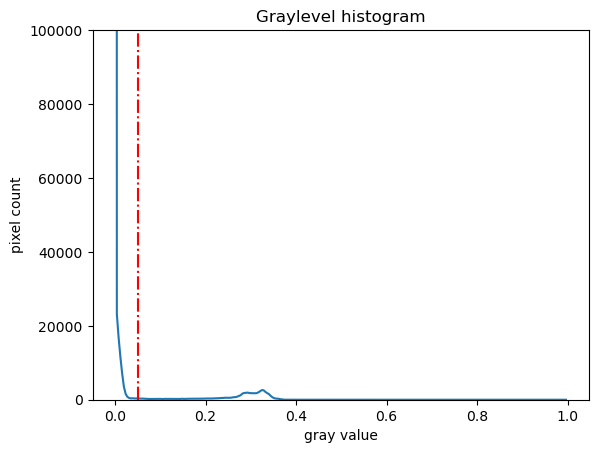

In [13]:
#determination of the optimal threshopld for segmentation
#different values for E. coli and Salmonella
thresholdValue = 0.05
gray_image = ski.color.rgb2gray(processedImgList[fileNameArray[1]])
histogram, bin_edges = np.histogram(gray_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.ylim(0,1e5)
plt.axvline(thresholdValue, linestyle= '-.', color='r')
plt.show()

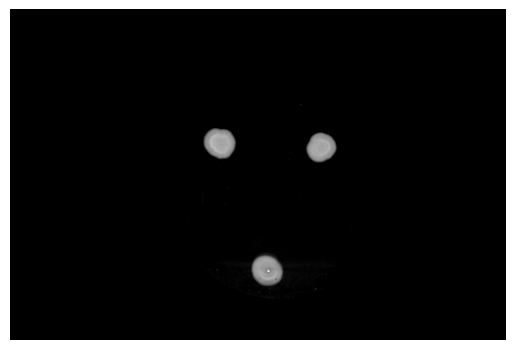

(np.float64(-0.5), np.float64(2399.5), np.float64(1599.5), np.float64(-0.5))

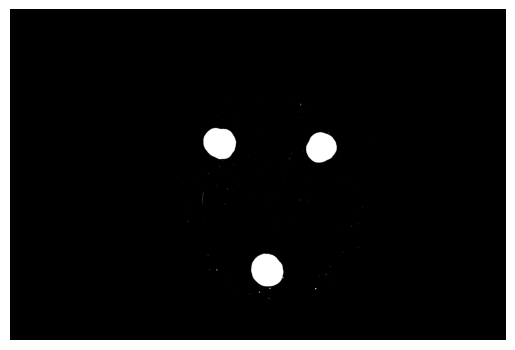

In [14]:
#Demonstration of gray scaling
choiceNum=1
plt.imshow(ski.color.rgb2gray(processedImgList[fileNameArray[choiceNum]]), 'gray')
plt.axis('off')
plt.show()

#Demonstration of thresholding
newgray=ski.color.rgb2gray(processedImgList[fileNameArray[choiceNum]])
mask = newgray>thresholdValue
plt.imshow(mask, 'gray')
plt.axis('off')

In [15]:
#now applying the area calculator
testingArea = {}
for x in processedImgList.keys():
    testingArea[x] =calculateArea(processedImgList[x], thresholdValue)

In [16]:
#print the results
print(testingArea)

{'flgK2_2_0.JPG': array([596.36399778, 928.33219305, 940.41179734]), 'flgK2_2_15.JPG': array([123.82904956, 139.48086169, 144.92529586]), 'flgK2_2_25.JPG': array([151.08117604, 163.265625  , 182.63193417]), 'flgK2_2_4.JPG': array([117.38859098, 122.57840237, 134.39589497]), 'flgK2_2_5.JPG': array([134.8602071 , 167.54178994, 185.11825074]), 'flgK2_2_6.JPG': array([555.75915311, 604.38461538, 685.78152737]), 'flgK2_2_7.JPG': array([1030.00157175, 1043.92344675, 1107.41438609]), 'flgK2_2_8.JPG': array([ 940.00739645,  942.0443787 , 1015.15107249])}


In [17]:
#save teh results
if True:
    with open("ecoli_plate_results/ecoli_tween.txt", 'w') as file:
        for x in testingArea.keys():
            file.write(x+" ")
            file.write(str(testingArea[x]) + str("\n"))

In [19]:
ecoli_surface_tension_values = pd.read_csv("ecoli_plate_results/ecoli-tween-dependency.csv")
ecoli_surface_tension_values

,Unnamed: 0,Tween Concentrations,Surface Tensions
0,0,-8.000000,71.166245
1,1,-7.000000,68.951667
2,2,-6.000000,56.269680
3,3,-5.000000,39.505200
4,4,-4.000000,35.404833
5,5,-3.823909,35.228776
6,6,-3.602060,35.085869


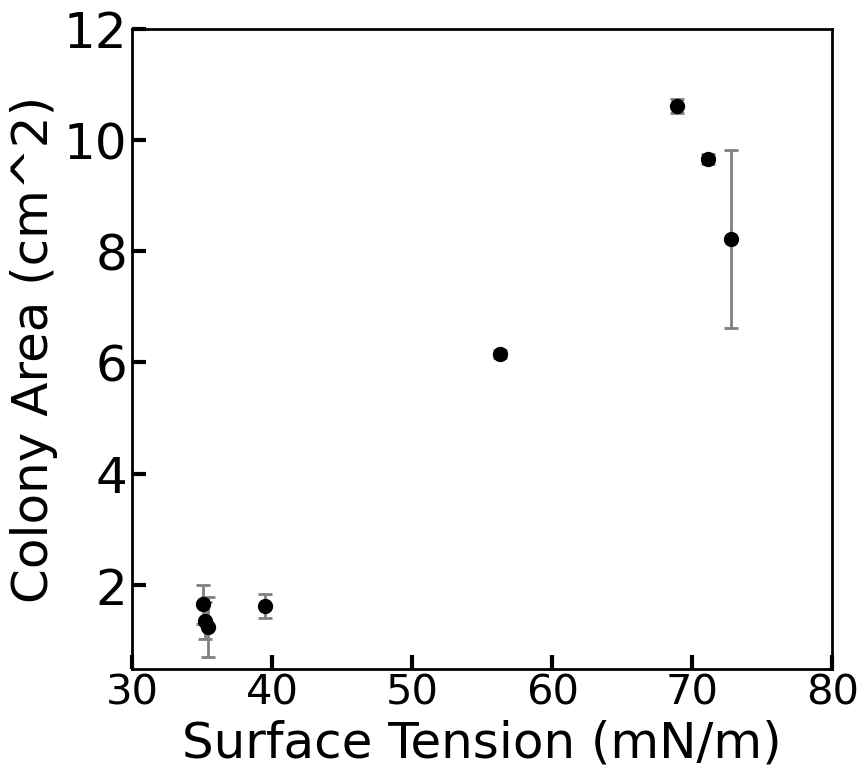

In [21]:
# load the data
key_start = 'flgK2_2_'
averages = []
for key in ['0', '8', '7', '6', '5', '4', '15', '25']:
    averages += [np.average(testingArea[key_start +  key + '.JPG'])]
errors = [np.std(testingArea[key]) for key in testingArea.keys()]
x_axis = np.concatenate((np.array([72.8]), ecoli_surface_tension_values['Surface Tensions']))

fig = plt.figure(figsize=(14,8))
ax = plt.axes((0.1,0.1,0.5,0.8))

'''ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')'''
ax.tick_params(axis='x', direction='in', labelsize=30, width=3, length=10)
ax.tick_params(axis='y', direction='in', labelsize=30, width=3, length=10)

ax.errorbar(x_axis, np.array(averages)/100, yerr=np.array(errors)/100, fmt='o', color='black', ecolor='grey', markersize=10, capsize=5, capthick=2, elinewidth=2)

plt.yticks(fontsize=36)

ax.set_ylim(0.5, 12)
ax.set_xlim(30, 80)
ax.set_ylabel("Colony Area (cm^2)", fontsize=36)
ax.set_xlabel("Surface Tension (mN/m)", fontsize=36)
ax.spines['bottom'].set_linewidth(2)  # Make the x-axis line thicker
ax.spines['left'].set_linewidth(2)    # Make the y-axis line thicker
ax.spines['top'].set_linewidth(2)  # Make the x-axis line thicker
ax.spines['right'].set_linewidth(2)    # Make the y-axis line thicker
plt.savefig("ecoli_plate_results/areas_plot.svg", dpi=300, bbox_inches='tight')
plt.show()